# 含参量子线路的等价性检查

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/zh_cn/advanced/mindspore_equivalence_checking_of_PQC.ipynb)&emsp;
[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/zh_cn/advanced/mindspore_equivalence_checking_of_PQC.py)&emsp;
[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindquantum/docs/source_zh_cn/advanced/equivalence_checking_of_PQC.ipynb)

## 概述

在量子设备上运行含参量子线路之前，需要将其编译成由该设备支持的量子门集组成的新线路。于是，需要对编译前后的两个线路进行等价性检查。论文Equivalence Checking of Parameterized Quantum Circuits中提出了一种基于ZX演算的含参量子线路等价性检查方法，本文尝试在MindSpore Quantum架构中复现论文中的方法。

论文链接：https://doi.org/10.1145/3566097.3567932

In [1]:
# 引入相关库
from mindquantum.core.circuit import Circuit
import numpy as np
from mindquantum.core.gates import H, CNOT, RX, RZ
from mindquantum.core.circuit import dagger

## 第一步

准备量子线路

以Qiskit线路库中的TwoLocal线路为例。TwoLocal线路是由旋转层和纠缠层交替组成的含参线路，旋转层即作用在所有量子比特上的单量子门，纠缠层根据纠缠策略使用双量子门将量子比特纠缠起来。

构造一个作用在127位量子比特上、由三组旋转层和纠缠层交替组成、纠缠策略为循环纠缠的TwoLocal线路，共包含508个参数。旋转层是作用在每一个量子比特上的含参[RX](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.RX.html)门；循环纠缠层是由最后一个量子比特控制第一个量子比特的[CNOT](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.CNOTGate.html)门，以及依次由前一个量子比特控制后一个量子比特的[CNOT](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.CNOTGate.html)门。

In [2]:
# 每一组旋转层和纠缠层的组合就是一层ansatz线路
def build_ansatz(n_qubits, depth):
    circ = Circuit()    # 初始化量子线路

    for i in range(depth):
        for j in range(n_qubits):
            circ += RX(f'theta{i*n_qubits+j}').on(j)    # 每个量子比特上一个RX门
        circ += CNOT.on(0, n_qubits-1)    # 最后一个量子比特和第一个量子比特上一个CNOT门
        for j in range(n_qubits-1):
            circ += CNOT.on(j+1, j)    # 相邻两个量子比特上一个CNOT门，CNOT门作用在第j+1位，且受第j位控制

    for j in range(n_qubits):
        circ += RX(f'theta{depth*n_qubits+j}').on(j)    # 每个量子比特上一个RX门

    return circ

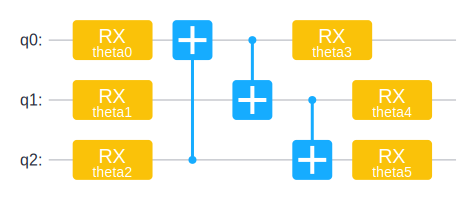

In [3]:
# 作用在3个量子比特上的一层ansatz线路示例
build_ansatz(3, 1).svg()

In [4]:
# 初始线路共3层，作用在127个量子比特上
n_qubits = 127
depth = 3
circ1 = build_ansatz(n_qubits, depth)
circ1.summary()    # 总结初始线路

                                       Circuit Summary                                       
╭───────────────────────┬───────────────────────────────────────────────────────────────────╮
│ Info                  │ value                                                             │
├───────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Number of qubit       │ 127                                                               │
├───────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Total number of gate  │ 889                                                               │
│ Barrier               │ 0                                                                 │
│ Noise Channel         │ 0                                                                 │
│ Measurement           │ 0                                                                 │
├───────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Parameter gate        │ 508                                                               │
│ 508 ansatz parameters │ theta0, theta1, theta2, theta3, theta4, theta5, theta6, theta7,   │
│                       │ theta8, theta9...                                                 │
╰───────────────────────┴───────────────────────────────────────────────────────────────────╯

接下来对初始量子线路进行编译。

假设编译前的量子门集为：[H](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.HGate.html)、[CNOT](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.CNOTGate.html)、[RZ](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.RZ.html)、[RX](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.RX.html)；编译后的量子门集为：[H](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.HGate.html)、[CNOT](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.CNOTGate.html)、[RZ](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.RZ.html)。编译规则是[H](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.HGate.html)、[CNOT](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.CNOTGate.html)、[RZ](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.RZ.html)门保持不变，将[RX](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.RX.html)门编译成[H](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.HGate.html)、[RZ](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.RZ.html)、[H](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.HGate.html)的组合。

In [5]:
def compile_circuit(circ):
    circ_compiled = Circuit()

    for gate in circ:    # 遍历初始线路中的量子门
        # H，CNOT，RZ门保持不变
        if gate.name == 'H' or gate.name == 'CNOT' or gate.name == 'RZ':
            circ_compiled += gate
        elif gate.name == 'RX':    # RX门经过编译变成H*RZ*H
            circ_compiled += H.on(gate.obj_qubits)
            circ_compiled += RZ(gate.coeff).on(gate.obj_qubits)
            circ_compiled += H.on(gate.obj_qubits)

    return circ_compiled

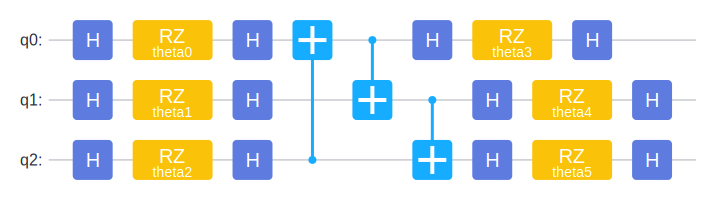

In [6]:
# 一层ansatz线路编译后生成的线路示例，可以看到，所有RX门都根据编译规则发生了变化
compile_circuit(build_ansatz(3, 1)).svg()

In [7]:
# 编译初始线路
circ2 = compile_circuit(circ1)
circ2.summary()    # 总结编译线路

                                       Circuit Summary                                       
╭───────────────────────┬───────────────────────────────────────────────────────────────────╮
│ Info                  │ value                                                             │
├───────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Number of qubit       │ 127                                                               │
├───────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Total number of gate  │ 1905                                                              │
│ Barrier               │ 0                                                                 │
│ Noise Channel         │ 0                                                                 │
│ Measurement           │ 0                                                                 │
├───────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Parameter gate        │ 508                                                               │
│ 508 ansatz parameters │ theta0, theta1, theta2, theta3, theta4, theta5, theta6, theta7,   │
│                       │ theta8, theta9...                                                 │
╰───────────────────────┴───────────────────────────────────────────────────────────────────╯

最后构造完整的量子线路。

根据量子线路的可逆性可知，若两个线路功能等价，那么将一个线路作用到量子比特上，再将另一个线路的逆线路作用到量子比特上，最终得到的量子态与两次作用之前的量子态等价。于是，完整的量子线路由编译后的线路和初始线路的逆线路组成。

In [8]:
# 完整线路
circ1_inv = dagger(circ1)    # dagger()将量子线路左右逆转，得到初始线路的逆线路
circ_all = circ1_inv + circ2    # 完整线路=初始线路的逆线路+编译后的线路
circ_all.summary()    # 总结完整线路

                                       Circuit Summary                                       
╭───────────────────────┬───────────────────────────────────────────────────────────────────╮
│ Info                  │ value                                                             │
├───────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Number of qubit       │ 127                                                               │
├───────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Total number of gate  │ 2794                                                              │
│ Barrier               │ 0                                                                 │
│ Noise Channel         │ 0                                                                 │
│ Measurement           │ 0                                                                 │
├───────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Parameter gate        │ 1016                                                              │
│ 508 ansatz parameters │ theta507, theta506, theta505, theta504, theta503, theta502,       │
│                       │ theta501, theta500, theta499, theta498...                         │
╰───────────────────────┴───────────────────────────────────────────────────────────────────╯

## 第二步

将完整的量子线路转换成ZX图。

含参量子线路等价性检查方法基于ZX演算实现，需要将量子线路转换成ZX图。

量子门是ZX图中的顶点，分为3种颜色，[H](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.HGate.html) 门表示成黄色顶点，[RX](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.RX.html) 门表示成含参的红色顶点，[RZ](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.RZ.html) 门表示成含参的绿色顶点，[CNOT](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.CNOTGate.html) 门的受控位表示成红色顶点，控制位表示成绿色顶点，受控位与控制位的顶点互为邻居。同一个量子比特上相邻两个量子门的顶点互为邻居。

先定义顶点类和图类。

In [9]:
# 顶点类
class Vertex:
    def __init__(self, name, color, qubit, neighbor, phase=0.0):
        self.name = name    # 量子门顶点的序号
        self.color = color    # 量子门顶点的颜色
        self.phase = phase   # 含参量子门的参数
        self.qubit = qubit     # 作用在哪个量子比特上
        self.neighbor = neighbor    # 顶点之间的邻居关系

In [10]:
# 图类
class Graph:
    def __init__(self):
        self.vertices = {}    # 初始图，空
        self.count = 0    # 顶点总数，只增不减，也用于给新顶点命名

    # 新增边
    def add_edge(self, from_vertex, to_vertex):    # 添加一条从起点到终点的边
        self.vertices[from_vertex].neighbor.append(to_vertex)

    # 新增顶点
    def add_vertex(self, color, qubit, neighbor, phase=0.0):
        name = self.count
        self.count += 1
        # 添加从新顶点到相邻顶点的边
        self.vertices[name] = Vertex(name, color, qubit, neighbor, phase)
        for v in neighbor:    # 再添加从相邻顶点到新顶点的边
            self.add_edge(v, name)

    # 打印图信息
    def print(self):
        print("==================graph message==================")
        for v in self.vertices.values():
            print(v.name, '\t', v.neighbor, '\t', v.color, '\t', v.phase)
        print('\n')

    # 删除自身的环
    # 省略了ZX图的无环规则（本文中，所有“无环”均指不存在单条边构成的环）
    def clear(self):
        for v in self.vertices.values():
            while v.name in v.neighbor:
                # 将本顶点从自己的邻居中删除
                self.vertices[v.name].neighbor.remove(v.name)

    # 删除顶点
    def delete_vertex(self, name):
        for v in self.vertices.values():
            while name in v.neighbor:    # 删除终点是该顶点的边
                self.vertices[v.name].neighbor.remove(name)
        self.vertices.pop(name)    # 删除起点是该顶点的边

    # 两个电路是否等价
    def equiv(self):
        if not self.vertices:    # 等价的两个电路，经过ZX演算化简后，图中无顶点
            print("Equivalent!")
        else:
            print("Not sure!")

接下来将量子线路绘制成ZX图。

遍历线路中的所有量子门，并依次将其绘制成ZX图中的顶点。若当前量子比特上暂无量子门，则当前的量子门暂无邻居；若当前量子比特上已有量子门，则当前的量子门与该量子比特上最后一个量子门互为邻居；[CNOT](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.CNOTGate.html) 门在绘制时就添加了控制位与受控位顶点之间的邻居关系。

In [11]:
def draw_graph(circ):
    g = Graph()    # 初始化一个空图
    last_name = [-1] * circ.n_qubits    # last_name保存每个量子比特上当前的最后一个顶点
    for gate in circ:    # 遍历线路中的所有量子门
        if gate.name == 'H':    # H门绘制成黄色顶点
            if last_name[gate.obj_qubits[0]] != -1:    # 当前量子比特上已有顶点
                g.add_vertex('yellow', gate.obj_qubits[0],
                             [last_name[gate.obj_qubits[0]]])
            else:    # 当前量子比特上暂无顶点
                g.add_vertex('yellow', gate.obj_qubits[0], [])
            last_name[gate.obj_qubits[0]] = g.count-1    # 更新当前量子比特上最后一个顶点为新增顶点
        if gate.name == 'RX':    # RX门绘制成红色顶点
            if last_name[gate.obj_qubits[0]] != -1:
                g.add_vertex('red', gate.obj_qubits[0],
                             [last_name[gate.obj_qubits[0]]], gate.coeff)
            else:
                g.add_vertex('red', gate.obj_qubits[0], [], gate.coeff)
            last_name[gate.obj_qubits[0]] = g.count-1
        if gate.name == 'RZ':    # RZ门绘制成绿色顶点
            if last_name[gate.obj_qubits[0]] != -1:
                g.add_vertex('green', gate.obj_qubits[0],
                             [last_name[gate.obj_qubits[0]]], gate.coeff)
            else:
                g.add_vertex('green', gate.obj_qubits[0], [], gate.coeff)
            last_name[gate.obj_qubits[0]] = g.count-1
        if gate.name == 'CNOT':    # CNOT门要分别绘制控制位顶点和受控位顶点
            # 绘制控制位顶点，绿色
            if last_name[gate.obj_qubits[1]] != -1:
                g.add_vertex('green', gate.obj_qubits[1],
                             [last_name[gate.obj_qubits[1]]])
            else:
                g.add_vertex('green', gate.obj_qubits[1], [])
            last_name[gate.obj_qubits[1]] = g.count-1
            # 绘制受控位顶点，红色
            if last_name[gate.obj_qubits[0]] != -1:
                g.add_vertex('red', gate.obj_qubits[0],
                             [last_name[gate.obj_qubits[0]], g.count-1])
            else:
                g.add_vertex('red', gate.obj_qubits[0], [g.count-1])
            last_name[gate.obj_qubits[0]] = g.count-1
    return g

最后，将第一步构造好的完整量子线路绘制成ZX图。

In [12]:
g = draw_graph(circ_all)

## 第三步

化简ZX图。

ZX演算由ZX图和化简规则组成，根据化简规则，对ZX图中的顶点和邻居关系进行化简。

以下列出部分规则，具体实现过程即图和顶点的相关操作，只举例说明，不再一一赘述。

规则1：不与其他量子比特上的顶点相邻的、参数为0的红色或绿色顶点可以删除。

![equivalence checking of PQC rule 1](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindquantum/docs/source_zh_cn/images/equivalence_checking_of_PQC_rule_1.jpg)

In [13]:
def rule_1(g: Graph):
    for v1 in list(g.vertices.keys()):    # ZX演算过程中，图中的顶点会发生增减，用list()获取最初的所有顶点
        if v1 not in g.vertices.keys():    # 判断当前顶点在化简过程中有没有被删除
            continue    # 已被删除，略过
        v1 = g.vertices[v1]
        # 顶点参数为0
        if v1.phase == 0 or list(v1.phase.values()) == [0.0]*len(list(v1.phase.values())):
            flag = True    # 用于判断当前顶点是否与其他量子比特上的顶点相关，如果相关，暂时不能删除
            for v2 in v1.neighbor:
                v2 = g.vertices[v2]
                if v2.qubit != v1.qubit:    # 与其他量子比特上的顶点相关
                    flag = False
                    break
            if flag:    # 与其他量子比特上的顶点无关
                for v2 in v1.neighbor:
                    v2 = g.vertices[v2]
                    v2.neighbor.extend(v1.neighbor)    # 将前一个顶点与后一个顶点相连，略过当前顶点
                    g.clear()    # 清除化简过程中可能产生的环
                g.delete_vertex(v1.name)    # 删除该顶点

规则2：相邻的、相同颜色的红色或绿色顶点可以合并。

![equivalence checking of PQC rule 2](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindquantum/docs/source_zh_cn/images/equivalence_checking_of_PQC_rule_2.jpg)

In [14]:
def rule_2(g: Graph):
    for v1 in list(g.vertices.keys()):
        if v1 not in g.vertices.keys():
            continue
        v1 = g.vertices[v1]
        if v1.color == 'red' or v1.color == 'green':    # 红色或绿色顶点
            for v2 in v1.neighbor:    # 相邻
                v2 = g.vertices[v2]
                if v2.color == v1.color:    # 相同颜色
                    v2.phase = v2.phase + v1.phase    # 参数相加
                    v2.neighbor.extend(v1.neighbor)    # 合并两个顶点
                    g.clear()
                    for v3 in v1.neighbor:    # 更新合并顶点后的邻居关系
                        v3 = g.vertices[v3]
                        v3.neighbor.append(v2.name)
                        g.clear()
                    g.delete_vertex(v1.name)    # 删除已被合并的顶点

规则3：所有邻居都是黄色顶点的绿色顶点，可以变成红色顶点，并删除相邻的黄色顶点。

![equivalence checking of PQC rule 3](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindquantum/docs/source_zh_cn/images/equivalence_checking_of_PQC_rule_3.jpg)

In [15]:
def rule_3(g: Graph):
    for v1 in list(g.vertices.keys()):
        if v1 not in g.vertices.keys():
            continue
        v1 = g.vertices[v1]
        if v1.color == 'green':
            flag = True    # 用于判断是否所有邻居都是黄色
            for v2 in v1.neighbor:
                v2 = g.vertices[v2]
                if v2.color != 'yellow':    # 不满足所有邻居都是黄色
                    flag = False
                    break
            if flag:    # 所有邻居都是黄色
                v1.color = 'red'    # 变成红色
                v1_neighbor = list(v1.neighbor)
                for v2 in v1_neighbor:    # 删除这些黄色顶点
                    v2 = g.vertices[v2]
                    v1.neighbor.extend(v2.neighbor)
                    g.clear()
                    for v3 in v2.neighbor:
                        v3 = g.vertices[v3]
                        v3.neighbor.append(v1.name)
                        g.clear()
                    g.delete_vertex(v2.name)

规则 4：相邻的、存在两条边的红绿顶点，可以删除这两条边。

![equivalence checking of PQC rule 4](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindquantum/docs/source_zh_cn/images/equivalence_checking_of_PQC_rule_4.jpg)

In [16]:
def rule_4(g: Graph):
    for v1 in list(g.vertices.keys()):
        if v1 not in g.vertices.keys():
            continue
        v1 = g.vertices[v1]
        if v1.color == 'green':
            for v2 in v1.neighbor:
                v2 = g.vertices[v2]
                # 红绿顶点，且两顶点间有两条边
                if v2.color == 'red' and v2.neighbor.count(v1.name) == 2:
                    while v2.name in g.vertices[v1.name].neighbor:    # 删除相连的边
                        v1.neighbor.remove(v2.name)
                    while v1.name in g.vertices[v2.name].neighbor:
                        v2.neighbor.remove(v1.name)

接下来利用以上规则对ZX图进行循环化简，若某轮循环中没有删除任何顶点，则认为化简结束。

In [17]:
def simplify(g: Graph):
    temp = []    # 用于对比本轮循环是否有顶点被删除
    while temp != list(g.vertices.keys()):    # 如果本轮循环没有删除任何顶点，则认为化简结束，退出循环
        temp = list(g.vertices.keys())
        rule_3(g)
        rule_2(g)
        rule_4(g)
        rule_1(g)

完整线路规模较大，可以先构造一个作用在三个量子比特上的单层线路进行测试。

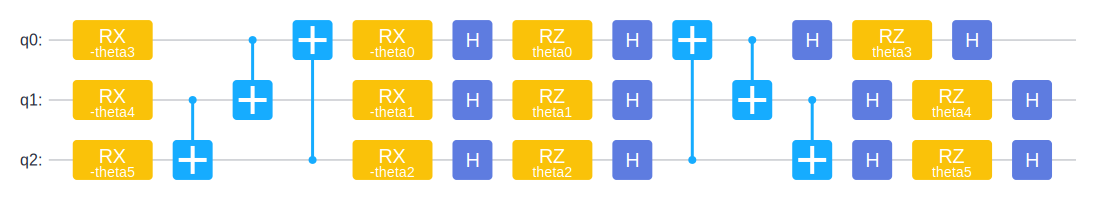

In [18]:
test_circ1 = build_ansatz(3, 1)
test_circ1_inv = dagger(test_circ1)
test_circ2 = compile_circuit(test_circ1)

test_circ_all = test_circ1_inv + test_circ2

test_circ_all.svg()

In [19]:
# 将测试线路绘制成ZX图
test_g = draw_graph(test_circ_all)
test_g.print()

==================graph message==================
0 	 [4] 	 red 	 -theta5
1 	 [3] 	 red 	 -theta4
2 	 [5] 	 red 	 -theta3
3 	 [1, 4, 6] 	 green 	 0.0
4 	 [0, 3, 7] 	 red 	 0.0
5 	 [2, 6, 8] 	 green 	 0.0
6 	 [3, 5, 10] 	 red 	 0.0
7 	 [4, 8, 9] 	 green 	 0.0
8 	 [5, 7, 11] 	 red 	 0.0
9 	 [7, 18] 	 red 	 -theta2
10 	 [6, 15] 	 red 	 -theta1
11 	 [8, 12] 	 red 	 -theta0
12 	 [11, 13] 	 yellow 	 0.0
13 	 [12, 14] 	 green 	 theta0
14 	 [13, 22] 	 yellow 	 0.0
15 	 [10, 16] 	 yellow 	 0.0
16 	 [15, 17] 	 green 	 theta1
17 	 [16, 24] 	 yellow 	 0.0
18 	 [9, 19] 	 yellow 	 0.0
19 	 [18, 20] 	 green 	 theta2
20 	 [19, 21] 	 yellow 	 0.0
21 	 [20, 22, 26] 	 green 	 0.0
22 	 [14, 21, 23] 	 red 	 0.0
23 	 [22, 24, 27] 	 green 	 0.0
24 	 [17, 23, 25] 	 red 	 0.0
25 	 [24, 26, 30] 	 green 	 0.0
26 	 [21, 25, 33] 	 red 	 0.0
27 	 [23, 28] 	 yellow 	 0.0
28 	 [27, 29] 	 green 	 theta3
29 	 [28] 	 yellow 	 0.0
30 	 [25, 31] 	 yellow 	 0.0
31 	 [30, 32] 	 green 	 theta4
32 	 [31] 	 yellow 	 0.0
33 	 [

In [20]:
# 化简测试线路
print("化简之前：")
test_g.equiv()

simplify(test_g)

print("化简之后：")
test_g.equiv()

化简之前：
Not sure!
化简之后：
Equivalent!


化简功能测试通过，最后就可以化简完整线路的ZX图，化简结果显示编译前后的两个线路是等价的。

In [21]:
# 化简完整线路
print("化简之前：")
g.equiv()

simplify(g)    # 化简

print("化简之后：")
g.equiv()

化简之前：
Not sure!


化简之后：
Equivalent!


## 第四

若ZX演算无法确定则实例化参数。

对于两个不等价的线路，ZX演算不能直接给出不等价的判定结果。这时，需要对线路中的参数进行实例化，判断实例化之后的两个线路是否等价。

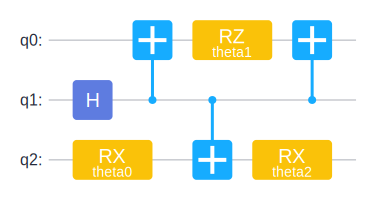

In [22]:
# 构造反例线路：ZX演算化简后无法确定、实际上不等价的两个线路
neq_circ1 = Circuit()
neq_circ1 += H.on(1)
neq_circ1 += RX(f'theta{0}').on(2)
neq_circ1 += CNOT.on(0, 1)
neq_circ1 += RZ(f'theta{1}').on(0)
neq_circ1 += CNOT.on(2, 1)
neq_circ1 += CNOT.on(0, 1)
neq_circ1 += RX(f'theta{2}').on(2)

neq_circ1.svg()

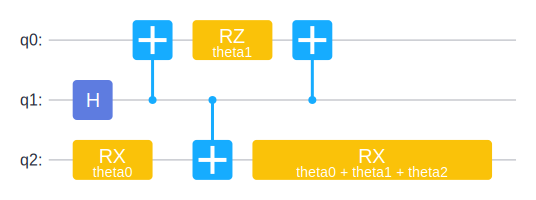

In [23]:
neq_circ2 = Circuit()
neq_circ2 += H.on(1)
neq_circ2 += RX(f'theta{0}').on(2)
neq_circ2 += CNOT.on(0, 1)
neq_circ2 += RZ(f'theta{1}').on(0)
neq_circ2 += CNOT.on(2, 1)
neq_circ2 += CNOT.on(0, 1)
neq_circ2 += RX({f'theta{0}': 1, f'theta{1}': 1, f'theta{2}': 1}).on(2)

neq_circ2.svg()

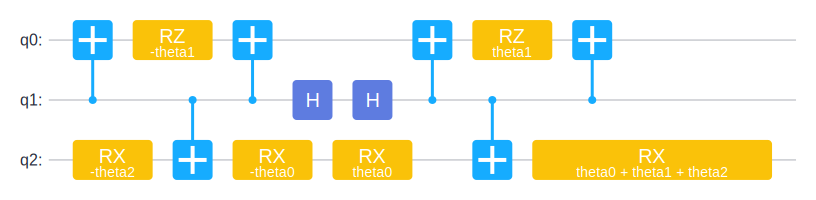

In [24]:
neq_circ1_inv = dagger(neq_circ1)
neq_circ_all = neq_circ1_inv + neq_circ2    # 构造完整反例线路
neq_circ_all.svg()

In [25]:
# 将反例线路绘制成ZX图并进行化简
neq_g = draw_graph(neq_circ_all)
print("化简之前：")
neq_g.equiv()

simplify(neq_g)

print("化简之后：")
neq_g.equiv()

化简之前：
Not sure!
化简之后：
Not sure!


对于反例线路，ZX演算化简之后，ZX图中仍有未删掉的顶点，于是ZX演算无法确定其等价性，需要实例化参数进行验证。

实例化参数步骤分为两步：

第一步，根据映射函数实例化参数，直接比较实例化之后两个线路的矩阵形式是否等价，若不等价则停止；

第二步，若映射函数实例化未得到不等价的结果，则随机实例化参数，再直接比较实例化之后两个线路的矩阵形式是否等价，若不等价则最终判定两个线路不等价，否则，最终判定两个线路等价。

In [26]:
# 映射函数实例化参数
def map_para(n, r):
    para = {}
    for i in range(n):
        para[f'theta{i}'] = (2*np.pi/((i+1)*r)-np.pi)
    return para


# 随机实例化参数
def random_para(n):
    para = {}
    for i in range(n):
        para[f'theta{i}'] = (np.random.uniform(np.pi, -np.pi))
    return para

In [27]:
# 实例化参数验证两个线路是否等价，验证r轮
def verify_by_para(circ1, circ2, r):
    n = len(list(set(circ1.params_name+circ2.params_name)))    # 线路中一共n个参数
    flag = True    # 记录前r-1轮验证是否有结果
    for i in range(r-1):    # 前r-1轮指定参数
        para = map_para(n, i+1)

        # 直接比较两个实例化之后的线路的矩阵形式是否等价
        if np.array_equal(circ1.matrix(para), circ2.matrix(para)):
            continue
        else:
            print('Not equivalent!')    # 在任一情况下两个线路的矩阵不等价，即表示这两个线路不等价
            flag = False    # 验证已有结果，结束
            break

    if flag:    # 前r-1轮没有结果，最后一轮随机参数
        para = random_para(n)
        if np.array_equal(circ1.matrix(para), circ2.matrix(para)):
            print('Equivalent!')
        else:
            print('Not equivalent!')

用实例化参数的方法去验证两个反例线路的等价性，结果为不等价。

In [28]:
verify_by_para(neq_circ1, neq_circ2, 5)

Not equivalent!


## 最后：将以上过程合并成一个完整的功能

In [29]:
def ZXcalculus(circ1, circ2):
    circ1_inv = dagger(circ1)    # 将原始线路左右逆转
    circ = circ1_inv + circ2    # 构造完整线路
    g = draw_graph(circ)    # 将完整线路绘制成ZX图
    print("化简之前：")
    g.equiv()
    simplify(g)    # 根据ZX演算规则进行化简
    print("化简之后：")
    if not g.vertices:    # 化简得到两个线路等价的结果
        g.equiv()
    else:    # 化简未能得到结果，需要实例化参数进行验证
        g.equiv()
        print("实例化参数验证：")
        verify_by_para(circ1, circ2, 5)

In [30]:
from mindquantum.utils.show_info import InfoTable

InfoTable('mindquantum', 'scipy', 'numpy')

Software,Version
mindquantum,0.9.11
scipy,1.9.3
numpy,1.23.5
System,Info
Python,3.8.17
OS,Linux x86_64
Memory,16.62 GB
CPU Max Thread,16
Date,Tue Jan 2 17:38:24 2024
